In [22]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
fitter = fitting.LinearLSQFitter()
from scipy.ndimage import median_filter
from scipy.interpolate import interp1d


In [23]:
fname='../../Type1/OGLEJ050650.94-700052.7/ADP.2020-11-16T16:11:14.683.fits'
harps='../../Type1/OGLEJ050650.94-700052.7/HARPS2005/ADP.2014-10-02T10:01:36.517.fits'
mucent='../../Mu_Centauri/ADP.2016-09-21T11:56:32.916.fits'

In [24]:
fits.getheader(harps)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
DATASUM = '0       '           / data unit checksum updated 2014-09-29T22:52:45 
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H   
DATE    = '2010-07-28T12:24:31.372' / Date this file was written                
INSTRUME= 'HARPS   '           / Instrument used                                
RA      =            76.694380 / 05:06:46.6 RA (J2000) pointing                 
DEC     =            -70.03706 / -70:02:13.4 DEC (J2000) pointing               
EQUINOX =                2000. / Standard FK5 (years)                           
RADECSYS= 'FK5     '        

In [17]:
fits.info(fname)

Filename: ../../Type1/OGLEJ050650.94-700052.7/ADP.2020-11-16T16:11:14.683.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1011   ()      
  1  SPECTRUM      1 BinTableHDU     71   1R x 6C   [131644D, 131644E, 131644E, 131644E, 131644E, 131644E]   


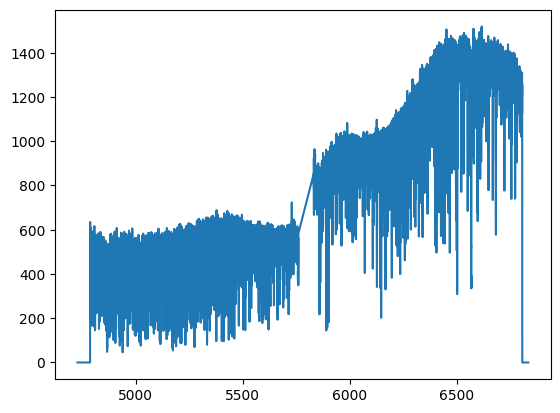

In [18]:
#plt.figure(figsize=(20,20))
#plt.imshow(fits.getdata(fname3).T[600:800],norm='log',vmin=200,aspect=10)
xd = fits.getdata(fname)
cent=fits.getdata(mucent)
#
harps=fits.getdata(harps)
xdNEW=xd['FLUX_REDUCED'][0]
lam = xd['WAVE'][0]
plt.plot(lam,xdNEW)

In [243]:
#UVES
xd_new=xd['FLUX'][0][4145:-1719].tolist()
xd_filt=median_filter(xd_new,50)
lam = xd['WAVE'][0][4145:-1719]

mask_alpha=np.abs(6562.8-lam)>40
mask_beta=np.abs(4861.33333333333-lam)>40
mask_gamma=np.abs(4367.23-lam)>50 #H_gamma está corrido
mask=mask_alpha&mask_beta&mask_gamma

#HARPS
xdH_new=harps['FLUX'][0][4145:-1719].tolist()
xdH_filt=median_filter(xdH_new,100)
lamH = harps['WAVE'][0][4145:-1719]

mask_alphaH=np.abs(6562.8-lamH)>40
mask_betaH=np.abs(4861.33333333333-lamH)>40
mask_gammaH=np.abs(4367.23-lamH)>50 #H_gamma está corrido
maskH=mask_alphaH&mask_betaH&mask_gammaH


#MuCen
cent_new=cent['FLUX'][0][4145:-1719].tolist()
cent_filt=median_filter(cent_new,150)
lamc = cent['WAVE'][0][4145:-1719]

mask_alphac=np.abs(6562.8-lamc)>40
mask_betac=np.abs(4861.33333333333-lamc)>40
mask_gammac=np.abs(4367.23-lamc)>50 #H_gamma está corrido
maskc=mask_alphac&mask_betac&mask_gammac

In [244]:
modelo = fitter(models.Chebyshev1D(25),lam[mask],xd_filt[mask])
modeloH = fitter(models.Chebyshev1D(25),lamH[maskH],xdH_filt[maskH])
modeloc = fitter(models.Chebyshev1D(25),lamc[maskc],cent_filt[maskc])
xd_filt[mask]

array([  0.        ,   0.        ,   0.        , ..., 126.96660614,
       126.96660614, 126.96660614], shape=(115451,))

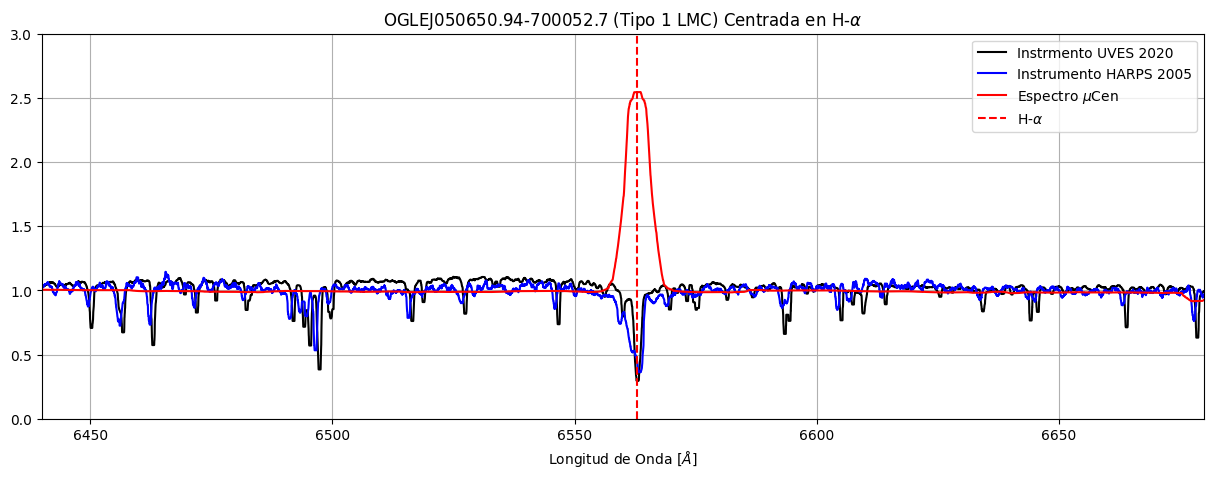

In [245]:
plt.figure(figsize=(15,5))
plt.plot(lam-5,xd_filt/modelo(lam), color='black', label='Instrmento UVES 2020')
plt.plot(lamH-5,xdH_filt/modeloH(lamH), color='blue', label='Instrumento HARPS 2005')
plt.plot(lamc,(cent_filt/modeloc(lamc)),color='red', label=r'Espectro $\mu$Cen')

plt.ylim(0,3)
plt.xlim(6440,6680)#H-alpha
plt.axvline(x=6562.8, color='r', linestyle='--', label=r'H-$\alpha$ ')
plt.xlabel(r'Longitud de Onda [$\AA$]')
plt.legend()
plt.title(r'OGLEJ050650.94-700052.7 (Tipo 1 LMC) Centrada en H-$\alpha$')
plt.margins(x=0)
plt.grid(True)
plt.savefig('harps_uves_type1LMC')

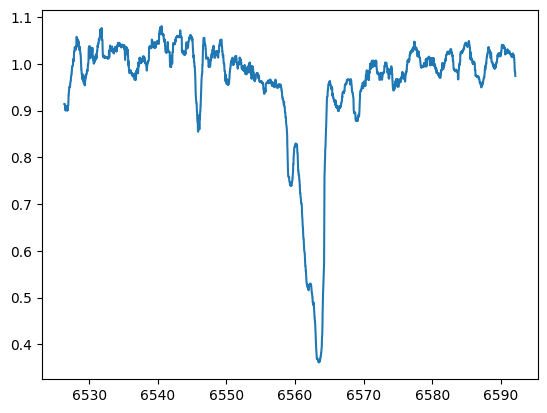

In [246]:
xU=(lam-5).tolist()[110540:-12849]
yU=(xd_filt/modelo(lam)).tolist()[110540:-12849]
xH=(lamH-5).tolist()[270840:-29849]
yH=(xdH_filt/modeloH(lamH)).tolist()[270840:-29849]

plt.plot(xH,yH)

In [247]:
def center_half_min_and_EW(x, y):
    min_idx = np.argmin(y)
    min_x = x[min_idx]
    min_y = y[min_idx]

    # Estimación del baseline
    left = y[:min_idx]
    right = y[min_idx+1:]
    baseline = 1

    # Estimación del ruido (std) en el continuo
    noise_std = np.std(np.concatenate([left[-5:], right[:5:]]))

    # Altura en FWHM
    half_depth = (baseline + min_y) / 2

    x_dense = np.linspace(x[0], x[-1], 10000)
    f_interp = interp1d(x, y, kind='linear')
    y_dense = f_interp(x_dense)

    # Centro en FWHM
    y_half = y_dense - half_depth
    crossings = np.where(np.diff(np.sign(y_half)))[0]

    if len(crossings) >= 2:
        x1 = x_dense[crossings[0]]
        x2 = x_dense[crossings[-1]]
        center = (x1 + x2) / 2
    else:
        x1, x2 = x_dense[0], x_dense[-1]
        center = min_x

    # Ancho equivalente
    delta_x = x_dense[1] - x_dense[0]
    normalized = 1 - (y_dense / baseline)
    ew = np.sum(normalized * delta_x)

    # Error
    in_line = (x_dense >= x1) & (x_dense <= x2)
    N = np.sum(in_line)
    ew_error = delta_x * np.sqrt(N) * (noise_std / baseline)

    return center, x1, x2, ew, ew_error



Ancho equivalente UVES: 0.846206 ± 0.000302
Ancho equivalente HARPS: 2.554685 ± 0.000011


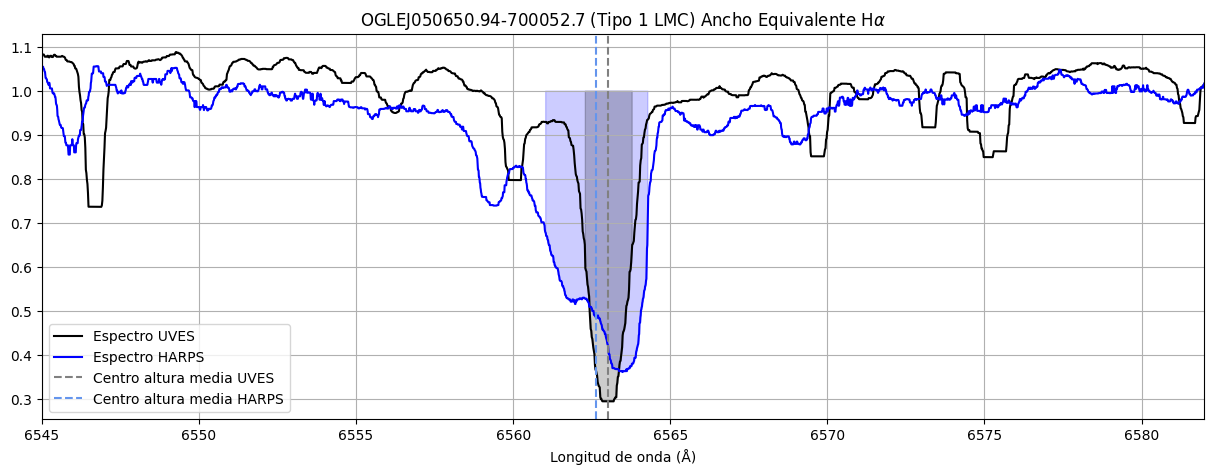

In [248]:
center_U, left_U, right_U, ew_U, ew_err_U = center_half_min_and_EW(xU, yU)
center_H, left_H, right_H, ew_H, ew_err_H = center_half_min_and_EW(xH, yH)

print(f"Ancho equivalente UVES: {ew_U:.6f} ± {ew_err_U:.6f}")
print(f"Ancho equivalente HARPS: {ew_H:.6f} ± {ew_err_H:.6f}")

distance = abs(center_H - center_U)

plt.figure(figsize=(15, 5))
plt.plot(xU, yU, label='Espectro UVES',color='black')
plt.plot(xH, yH, label='Espectro HARPS',color='blue')
plt.axvline(center_U, color='gray', linestyle='--', label='Centro altura media UVES')
plt.axvline(center_H, color='cornflowerblue', linestyle='--', label='Centro altura media HARPS')
plt.fill_between(xH, yH, 1, where=(xH > left_H) & (xH < right_H), color='blue', alpha=0.2)
plt.fill_between(xU, yU, 1, where=(xU > left_U) & (xU < right_U), color='black', alpha=0.2)
plt.xlabel("Longitud de onda (Å)")
plt.xlim(6545,6582)
plt.legend()
plt.title(r"OGLEJ050650.94-700052.7 (Tipo 1 LMC) Ancho Equivalente H$\alpha$")
plt.grid(True)
plt.savefig('distance.png')

plt.show()

In [19]:
# Buscar un espacio donde se asemeje
#$cf; centro de la caracteristica (H-alpha)
#cb: punto en el azul, cr: punto en el rojo